<a href="https://colab.research.google.com/github/pathikritsyam/ECTA/blob/main/ANN/ANN_PSO_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython.display import HTML, display

def my_css():
   display(HTML("""<style>table.dataframe td{white-space: nowrap;}</style>"""))

get_ipython().events.register('pre_run_cell', my_css)

In [ ]:
import tensorflow as tf
# Solo configurar GPU si está disponible
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print(f"GPU disponible: {physical_devices[0]}")
else:
    print("No hay GPU disponible. Usando CPU.")

# 04.02 - Exploratory Data Analysis & ANN & Genetic Algorithm - Full Notebook

## Imports & setup

In [ ]:
import pathlib
import datetime
from os import PathLike
from typing import Union

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import palettable
import seaborn as sns
%matplotlib inline

PROJECT_DIR = pathlib.Path.cwd().parent.resolve()
CLEAN_DATA_DIR = PROJECT_DIR / 'data' / '05-clean'

plt.style.use('grayscale')
# Custom Overrides to grayscale
params = {'legend.fontsize': 'x-large',
          'lines.linewidth': 0.75,
      'figure.figsize': (15, 7),
          'grid.color': 'white',
          'axes.axisbelow': False,
          'axes.grid': True,
          'axes.grid.axis': 'y',
     'axes.labelsize': 'x-large',
     'axes.titlesize':'xx-large',
     'xtick.labelsize':'x-large',
     'ytick.labelsize':'x-large'}
plt.rcParams.update(params)
figsize=(15,7)

## Load Data

In [ ]:
dtypes = {'Temperature': np.float64, 'Dewpoint Temp':np.float64, 'Relative Humidity':np.float64,
          'Wind Speed': np.float64, 'Visibility': np.float64, 'Pressure': np.float64,
          'Wind_Chill': np.float64,
         'Hour_of_Day': np.float64, 'Year': np.float64, 'Month': np.float64,
         'Day_Of_Week': np.float64, 'Day_of_Year': np.float64, 'Week_Of_Year': np.float64,
          'Quarter': np.float64, 'Stat_Hol': np.float64}


df_orig = pd.read_excel("../data/ECTA 2023 Dataset.xlsx")

# Convert Date column to datetime with dayfirst=True and handle errors
df_orig['Date'] = pd.to_datetime(df_orig['Date'], dayfirst=True, errors='coerce')

# Drop rows with invalid dates (NaT)
df_orig = df_orig.dropna(subset=['Date'])

# Set Date as index
df_orig.set_index('Date', inplace=True)

# Apply dtypes to relevant columns
for col, dtype in dtypes.items():
    if col in df_orig.columns:
        df_orig[col] = df_orig[col].astype(dtype)

daymapper = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
weekdaymapper = {0: 'Weekday', 1: 'Weekday', 2: 'Weekday', 3: 'Weekday', 4: 'Weekday',
                 5: 'Weekend', 6: 'Weekend'}
df_orig['dayofweek'] = df_orig['Day_Of_Week'].map(daymapper)
df_orig['daytype'] = df_orig['Day_Of_Week'].map(weekdaymapper)

print(f"Dataset loaded successfully. Shape: {df_orig.shape}")


In [ ]:
df_orig.head()

,temp,dew_point_temp,rel_hum,wind_speed,visibility,press,hmdx,wind_chill,weather,hour_of_day,...,day_of_week,day_of_year,week_of_year,quarter,stat_hol,day_light_hours,hourly_demand,daily_peak,dayofweek,daytype
1994-01-01 00:00:00,-1.2,-3.8,83.0,15.0,19.3,99.91,NaN,-6.0,Cloudy,0.0,...,5.0,1.0,52.0,1.0,True,False,14422.0,16892.0,Sat,Weekend
1994-01-01 01:00:00,-0.9,-3.0,86.0,20.0,16.1,99.91,NaN,-6.0,Cloudy,1.0,...,5.0,1.0,52.0,1.0,True,False,13845.0,16892.0,Sat,Weekend
1994-01-01 02:00:00,-0.7,-3.2,83.0,15.0,16.1,99.87,NaN,-5.0,Cloudy,2.0,...,5.0,1.0,52.0,1.0,True,False,13372.0,16892.0,Sat,Weekend
1994-01-01 03:00:00,-0.8,-2.4,89.0,15.0,12.9,99.81,NaN,-5.0,Cloudy,3.0,...,5.0,1.0,52.0,1.0,True,False,13025.0,16892.0,Sat,Weekend
1994-01-01 04:00:00,-1.0,-3.3,84.0,19.0,16.1,99.77,NaN,-6.0,Mostly Cloudy,4.0,...,5.0,1.0,52.0,1.0,True,False,12869.0,16892.0,Sat,Weekend


In [ ]:
df_orig.tail()

,temp,dew_point_temp,rel_hum,wind_speed,visibility,press,hmdx,wind_chill,weather,hour_of_day,...,day_of_week,day_of_year,week_of_year,quarter,stat_hol,day_light_hours,hourly_demand,daily_peak,dayofweek,daytype
2018-12-31 19:00:00,2.5,1.0,90.0,19.0,9.7,98.51,NaN,NaN,"Rain,Fog",19.0,...,0.0,365.0,1.0,4.0,False,False,16195.0,17125.0,Mon,Weekday
2018-12-31 20:00:00,2.9,1.6,92.0,21.0,9.7,98.17,NaN,NaN,"Rain,Fog",20.0,...,0.0,365.0,1.0,4.0,False,False,15668.0,17125.0,Mon,Weekday
2018-12-31 21:00:00,3.7,2.6,93.0,21.0,9.7,97.98,NaN,NaN,"Rain,Fog",21.0,...,0.0,365.0,1.0,4.0,False,False,14987.0,17125.0,Mon,Weekday
2018-12-31 22:00:00,4.0,3.0,93.0,18.0,6.4,97.61,NaN,NaN,"Rain,Fog",22.0,...,0.0,365.0,1.0,4.0,False,False,14560.0,17125.0,Mon,Weekday
2018-12-31 23:00:00,4.3,3.4,94.0,12.0,9.7,97.37,NaN,NaN,"Rain,Fog",23.0,...,0.0,365.0,1.0,4.0,False,False,13828.0,17125.0,Mon,Weekday


In [ ]:
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 219144 entries, 1994-01-01 00:00:00 to 2018-12-31 23:00:00
Data columns (total 22 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   temp             219144 non-null  float64 
 1   dew_point_temp   219144 non-null  float64 
 2   rel_hum          219144 non-null  float64 
 3   wind_speed       219144 non-null  float64 
 4   visibility       219144 non-null  float64 
 5   press            219144 non-null  float64 
 6   hmdx             34073 non-null   float64 
 7   wind_chill       48918 non-null   float64 
 8   weather          191377 non-null  object  
 9   hour_of_day      219144 non-null  float64 
 10  year             219144 non-null  float64 
 11  month            219144 non-null  float64 
 12  day_of_week      219144 non-null  float64 
 13  day_of_year      219144 non-null  float64 
 14  week_of_year     219144 non-null  float64 
 15  quarter          219144 non-null  

In [ ]:
for col in df_orig.columns:
    print(col)

temp
dew_point_temp
rel_hum
wind_speed
visibility
press
hmdx
wind_chill
weather
hour_of_day
year
month
day_of_week
day_of_year
week_of_year
quarter
stat_hol
day_light_hours
hourly_demand
daily_peak
dayofweek
daytype


In [ ]:
df_orig['year'].value_counts()

2008.0    8784
1996.0    8784
2016.0    8784
2000.0    8784
2012.0    8784
2004.0    8784
1994.0    8760
2017.0    8760
2015.0    8760
2014.0    8760
2013.0    8760
2011.0    8760
2010.0    8760
2009.0    8760
2006.0    8760
2007.0    8760
1995.0    8760
2005.0    8760
2003.0    8760
2002.0    8760
2001.0    8760
1999.0    8760
1998.0    8760
1997.0    8760
2018.0    8760
Name: year, dtype: int64

### Data for Every Hour in 2008

In [ ]:
pd.set_option('display.max_columns', 100)
df2018 = df_orig.loc['2010':'2015', :].copy(deep=True)
df2018.head()

In [ ]:
df2018.describe()

,temp,dew_point_temp,rel_hum,wind_speed,visibility,press,hmdx,wind_chill,hour_of_day,year,month,day_of_week,day_of_year,week_of_year,quarter,hourly_demand,daily_peak
count,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,4439.000000,5627.000000,26304.000000,26304.00000,26304.000000,26304.000000,26304.000000,26304.000000,26304.000000,26304.00000,26304.000000
mean,9.488975,3.204231,67.116617,16.419651,22.139716,99.540255,29.747015,-12.634086,11.500000,2016.00000,6.521898,3.005474,183.166971,26.739051,2.508212,15438.43214,17781.990876
std,11.257550,10.588788,16.612765,9.414445,5.169626,0.776109,3.643501,6.664495,6.922318,0.81614,3.449052,1.999574,105.464786,15.069330,1.117209,2326.83841,1859.117895
min,-26.000000,-31.600000,13.000000,0.000000,0.200000,96.490000,25.000000,-41.000000,0.000000,2015.00000,1.000000,0.000000,1.000000,1.000000,1.000000,10167.00000,13315.000000
25%,1.275000,-4.000000,55.000000,9.000000,24.100000,99.040000,27.000000,-17.000000,5.750000,2015.00000,4.000000,1.000000,92.000000,14.000000,2.000000,13682.00000,16391.750000
50%,9.800000,3.800000,68.000000,15.000000,24.100000,99.550000,29.000000,-11.000000,11.500000,2016.00000,7.000000,3.000000,183.000000,27.000000,3.000000,15353.00000,17600.500000
75%,18.800000,12.100000,80.000000,22.000000,24.100000,100.050000,32.000000,-7.000000,17.250000,2017.00000,10.000000,5.000000,274.250000,40.000000,4.000000,16989.00000,19137.000000
max,35.200000,24.800000,99.000000,80.000000,80.500000,102.210000,43.000000,0.000000,23.000000,2017.00000,12.000000,6.000000,366.000000,53.000000,4.000000,23213.00000,23213.000000


In [ ]:
import sklearn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [ ]:
df2018.columns

Index(['temp', 'dew_point_temp', 'rel_hum', 'wind_speed', 'visibility',
       'press', 'hmdx', 'wind_chill', 'weather', 'hour_of_day', 'year',
       'month', 'day_of_week', 'day_of_year', 'week_of_year', 'quarter',
       'stat_hol', 'day_light_hours', 'hourly_demand', 'daily_peak',
       'dayofweek', 'daytype'],
      dtype='object')

In [ ]:
features_train=df2018[['Temperature', 'Dewpoint Temp', 'Relative Humidity','Wind Speed', 'Visibility', 'Pressure','Hour_of_Day','Month','Day_Of_Week', 'Day_of_Year', 'Week_Of_Year','Quarter']]
features_train
scaler=StandardScaler()
Train=scaler.fit_transform(np.array(features_train))
Train

In [ ]:
cmatrix = features_train.corr()
round(cmatrix, ndigits=5)

,temp,dew_point_temp,rel_hum,wind_speed,visibility,press,hour_of_day,month,day_of_week,day_of_year,week_of_year,quarter,daily_peak,hourly_demand
temp,1.00000,0.93092,-0.19943,-0.13643,0.17613,-0.19779,0.10200,0.31465,-0.02379,0.31298,0.29985,0.32398,-0.13083,-0.03795
dew_point_temp,0.93092,1.00000,0.16561,-0.21914,0.02653,-0.28445,0.00918,0.35694,-0.03173,0.35482,0.34316,0.36499,-0.11927,-0.11255
rel_hum,-0.19943,0.16561,1.00000,-0.23205,-0.48302,-0.25033,-0.25377,0.09656,-0.02190,0.09570,0.09896,0.09286,0.02460,-0.19952
wind_speed,-0.13643,-0.21914,-0.23205,1.00000,0.07252,-0.27084,0.14320,-0.10065,0.01484,-0.09949,-0.09086,-0.09713,0.02249,0.17997
visibility,0.17613,0.02653,-0.48302,0.07252,1.00000,0.22024,0.03811,0.06689,0.02719,0.06945,0.06995,0.07781,-0.06879,-0.06685
press,-0.19779,-0.28445,-0.25033,-0.27084,0.22024,1.00000,-0.01233,0.07634,0.04226,0.07436,0.07249,0.06912,0.01106,-0.01237
hour_of_day,0.10200,0.00918,-0.25377,0.14320,0.03811,-0.01233,1.00000,-0.00000,-0.00000,-0.00000,-0.00000,-0.00000,-0.00000,0.46521
month,0.31465,0.35694,0.09656,-0.10065,0.06689,0.07634,-0.00000,1.00000,0.00025,0.99650,0.97588,0.97140,-0.08896,-0.12068
day_of_week,-0.02379,-0.03173,-0.02190,0.01484,0.02719,0.04226,-0.00000,0.00025,1.00000,0.00000,-0.00468,0.00406,-0.29188,-0.20896
day_of_year,0.31298,0.35482,0.09570,-0.09949,0.06945,0.07436,-0.00000,0.99650,0.00000,1.00000,0.97779,0.96823,-0.08509,-0.11746


In [ ]:
pd.set_option('display.max_columns', 100)

dftest = df_orig.loc['2016', :].copy(deep=True)
# dftest.head()
features_test= dftest[['Temperature', 'Dewpoint Temp', 'Relative Humidity','Wind Speed', 'Visibility', 'Pressure','Hour_of_Day','Month','Day_Of_Week', 'Day_of_Year', 'Week_Of_Year','Quarter']]
Test=scaler.fit_transform(np.array(features_test))
Test

In [ ]:
# x_train=Train[:,:-1]
# y_train=Train[:,-1]
# x_test=Test[:,:-1]
# y_test=Test[:,-1]

In [ ]:
print(Train[0,:-1])
print(Train[1,:-1])
print(Train[2,:-1])
print(np.concatenate((Train[0,:-1], Train[1,:-1], Train[2,:-1])))

[-1.50914702 -1.76645216 -0.84976132  1.12386343  0.37919975 -0.11629443
 -1.66132477 -1.60102055 -0.00273786 -1.72731051 -1.70807466 -1.35000774
  0.11834285]
[-1.51803011 -1.82311695 -0.97015296  1.12386343  0.37919975 -0.21937465
 -1.51686175 -1.60102055 -0.00273786 -1.72731051 -1.70807466 -1.35000774
  0.11834285]
[-1.5446794  -1.76645216 -0.72936969  1.2300852   0.37919975 -0.29668481
 -1.37239873 -1.60102055 -0.00273786 -1.72731051 -1.70807466 -1.35000774
  0.11834285]
[-1.50914702 -1.76645216 -0.84976132  1.12386343  0.37919975 -0.11629443
 -1.66132477 -1.60102055 -0.00273786 -1.72731051 -1.70807466 -1.35000774
  0.11834285 -1.51803011 -1.82311695 -0.97015296  1.12386343  0.37919975
 -0.21937465 -1.51686175 -1.60102055 -0.00273786 -1.72731051 -1.70807466
 -1.35000774  0.11834285 -1.5446794  -1.76645216 -0.72936969  1.2300852
  0.37919975 -0.29668481 -1.37239873 -1.60102055 -0.00273786 -1.72731051
 -1.70807466 -1.35000774  0.11834285]


In [ ]:
np.stack([Train[j,-1] for j in range(0, 12)])

array([-0.20561859, -0.41363011, -0.62722872, -0.76002947, -0.80429638,
       -0.70974569, -0.64227088, -0.51333812, -0.46219479, -0.25461304,
       -0.04617174,  0.08533968])

In [ ]:
print(Train.shape)
print(Train[2:].shape)
x_train = np.array([np.concatenate((Train[i-2], Train[i-1], Train[i])) for i in range(2, len(Train)-24)])
x_test = np.array([np.concatenate((Test[i-2], Test[i-1], Test[i])) for i in range(2, len(Test)-24)])[:500]
print(f'x_train.shape: {x_train.shape} x_test.shape: {x_test.shape}')
y_train = np.array([np.stack([Train[i+j+1,-1] for j in range(0, 24)]) for i in range(2, len(Train)-24)])
y_test = np.array([np.stack([Test[i+j+1,-1] for j in range(0, 24)]) for i in range(2, len(Test)-24)])[:500]
print(f'y_train.shape: {y_train.shape} y_test.shape: {y_test.shape}')

##Particle Swarm Optimisation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25)

In [ ]:
def ANN_model(lr, batch_sz, ep):
  model = Sequential()
  # Defining the input layer
  # model.add(Dense(units=f1, input_dim=x_train.shape[1], kernel_initializer='normal', activation=a1))
  model.add(Dense(units=36, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-5), bias_regularizer=regularizers.L2(1e-5), activity_regularizer=regularizers.L2(1e-5)))


  # Defining the  two hidden layers
  # model.add(Dense(units=f2, kernel_initializer='normal', activation=a2))
  model.add(Dense(units=64, kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-5), bias_regularizer=regularizers.L2(1e-5), activity_regularizer=regularizers.L2(1e-5)))
  model.add(Dense(units=36, kernel_initializer='normal', activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-5), bias_regularizer=regularizers.L2(1e-5), activity_regularizer=regularizers.L2(1e-5)))



  # Defining the output layer of the model
  model.add(Dense(24, kernel_initializer='normal',activation='linear'))

  # if op == "sgd":
  #   op = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.5, decay=0.009, nesterov=True)

  # elif op == "adamax":
  #   op = tf.keras.optimizers.Adamax(learning_rate=lr, beta_1=0.9,beta_2=0.999,epsilon=1e-07)

  # elif op == "adam":
  #   op = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

  # elif op == "adagrad":
  #   op = tf.keras.optimizers.Adagrad(learning_rate=lr, initial_accumulator_value=0.1,epsilon=1e-07)

  # else:
  #   op == tf.keras.optimizers.Nadam(learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

  # Compiling the model
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.01,decay_steps=10000,decay_rate=0.9)
  optimiser = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

  # Compiling the model
  model.compile(loss='mean_squared_error', optimizer='Adam')

  # Early_Stopping
  callback = [EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5, min_delta=0.0001),
              # ModelCheckpoint(filepath="fname.hdf5", save_weights_only=True, monitor='val_loss', mode='max', save_best_only=True)
              ]

  # Fitting the ANN to the Training set
  model.fit(x_train, y_train, batch_size = batch_sz, epochs = ep,validation_data=(x_val,y_val),callbacks=[callback],verbose=1)

  return model

In [ ]:
# Define the range of hyperparameters
lr_range = (0.01, 0.5)
epoch_range = (10, 100)
batch_size_range = (16, 256)

# Define the number of particles and maximum iterations
num_particles = 5
max_iterations = 5

In [ ]:
# Fitness evaluation metric: Classification Accuracy
from keras.losses import mean_squared_error as MSE
from keras.losses import MeanAbsoluteError
def fitness_function(learning_rate, epoch, batch_size):
    # Your implementation of ANN training and evaluation here
    epoch=int(epoch)
    batch_size=int(batch_size)
    model=ANN_model(learning_rate, batch_size, epoch)
    MSE = tf.keras.losses.MeanSquaredError()
    metrics = MSE(y_test, model.predict(x_test)).numpy().mean()
    print(f"metrics:{metrics}")
    # Return the fitness value (e.g., error or accuracy)
    return metrics

In [ ]:
# Define the Particle class
class Particle:
    def __init__(self):
        self.position = np.array([random.uniform(*lr_range),
                                  random.uniform(*epoch_range),
                                  random.randint(*batch_size_range)])
        self.velocity = np.zeros(3)
        self.best_position = self.position.copy()
        self.best_fitness = float('inf')

    def update_velocity(self, global_best_position, inertia_weight, cognitive_weight, social_weight):
        self.velocity = (inertia_weight * self.velocity +
                         cognitive_weight * random.uniform(0, 1) * (self.best_position - self.position) +
                         social_weight * random.uniform(0, 1) * (global_best_position - self.position))

    def update_position(self):
        self.position += self.velocity

        # Ensure the position is within the valid range
        self.position[0] = np.clip(self.position[0], *lr_range)
        self.position[1] = np.clip(self.position[1], *epoch_range)
        self.position[2] = np.clip(self.position[2], *batch_size_range)

    def evaluate_fitness(self):
        fitness = fitness_function(*self.position)

        # Update personal best if the fitness is improved
        if fitness < self.best_fitness:
            self.best_fitness = fitness
            self.best_position = self.position.copy()

        return fitness

In [ ]:
# Define the PSO class
class PSO:
    def __init__(self):
        self.global_best_position = np.array([random.uniform(*lr_range),
                                              random.uniform(*epoch_range),
                                              random.randint(*batch_size_range)])
        self.global_best_fitness = float('inf')
        self.particles = []

    def initialize_particles(self):
        for _ in range(num_particles):
            particle = Particle()
            self.particles.append(particle)

    def update_global_best(self):
        for particle in self.particles:
            if particle.best_fitness < self.global_best_fitness:
                self.global_best_fitness = particle.best_fitness
                self.global_best_position = particle.best_position.copy()

    def optimize(self):
        self.initialize_particles()

        for iteration in range(max_iterations):
            for particle in self.particles:
                particle.update_velocity(self.global_best_position, 0.5, 0.8, 0.8)
                particle.update_position()
                fitness = particle.evaluate_fitness()

                # Update global best if the fitness is improved
                if fitness < self.global_best_fitness:
                    self.global_best_fitness = fitness
                    self.global_best_position = particle.position.copy()

            best_lr, best_epoch, best_batch_size = self.global_best_position
            best_epoch=int(best_epoch)
            best_batch_size=int(best_batch_size)
            print("Iteration:", iteration + 1)
            print("Modified Hyperparameters:")
            print("Learning Rate:", best_lr)
            print("Epoch:", int(best_epoch))
            print("Batch Size:", int(best_batch_size))
            print()



In [ ]:
# Usage
pso = PSO()
pso.optimize()

# Retrieve the optimized hyperparameters
best_lr, best_epoch, best_batch_size = pso.global_best_position
print("Optimized Hyperparameters:")
print("Learning Rate:", best_lr)
print("Epoch:", int(best_epoch))
print("Batch Size:", int(best_batch_size))

Epoch 1/40
157/157 [==============================] - 2s 5ms/step - loss: 0.5795 - val_loss: 0.3373
Epoch 2/40
157/157 [==============================] - 1s 4ms/step - loss: 0.2282 - val_loss: 0.1788
Epoch 3/40
157/157 [==============================] - 1s 4ms/step - loss: 0.1531 - val_loss: 0.1335
Epoch 4/40
157/157 [==============================] - 1s 4ms/step - loss: 0.1250 - val_loss: 0.1196
Epoch 5/40
157/157 [==============================] - 1s 3ms/step - loss: 0.1138 - val_loss: 0.1083
Epoch 6/40
157/157 [==============================] - 1s 4ms/step - loss: 0.1057 - val_loss: 0.1028
Epoch 7/40
157/157 [==============================] - 1s 3ms/step - loss: 0.0988 - val_loss: 0.0952
Epoch 8/40
157/157 [==============================] - 1s 4ms/step - loss: 0.0932 - val_loss: 0.0908
Epoch 9/40
157/157 [==============================] - 1s 3ms/step - loss: 0.0881 - val_loss: 0.0845
Epoch 10/40
157/157 [==============================] - 1s 3ms/step - loss: 0.0832 - val_loss: 0.0797

In [ ]:
model=ANN_model(best_lr, int(best_batch_size), int(best_epoch))

Epoch 1/84
481/481 [==============================] - 4s 5ms/step - loss: 0.3397 - val_loss: 0.1490
Epoch 2/84
481/481 [==============================] - 1s 3ms/step - loss: 0.1260 - val_loss: 0.1142
Epoch 3/84
481/481 [==============================] - 1s 3ms/step - loss: 0.1063 - val_loss: 0.1007
Epoch 4/84
481/481 [==============================] - 1s 3ms/step - loss: 0.0931 - val_loss: 0.0876
Epoch 5/84
481/481 [==============================] - 1s 3ms/step - loss: 0.0834 - val_loss: 0.0794
Epoch 6/84
481/481 [==============================] - 1s 3ms/step - loss: 0.0773 - val_loss: 0.0796
Epoch 7/84
481/481 [==============================] - 1s 3ms/step - loss: 0.0722 - val_loss: 0.0699
Epoch 8/84
481/481 [==============================] - 1s 3ms/step - loss: 0.0684 - val_loss: 0.0660
Epoch 9/84
481/481 [==============================] - 2s 3ms/step - loss: 0.0664 - val_loss: 0.0657
Epoch 10/84
481/481 [==============================] - 2s 4ms/step - loss: 0.0645 - val_loss: 0.0634

In [ ]:
MAPE = mean_absolute_percentage_error(y_test, model.predict(x_test))
print("MAPE: ",MAPE)

16/16 [==============================] - 0s 2ms/step
MAPE:  0.8985515921915389


In [ ]:
y_test[:, 1].shape

(500,)

16/16 [==============================] - 0s 1ms/step


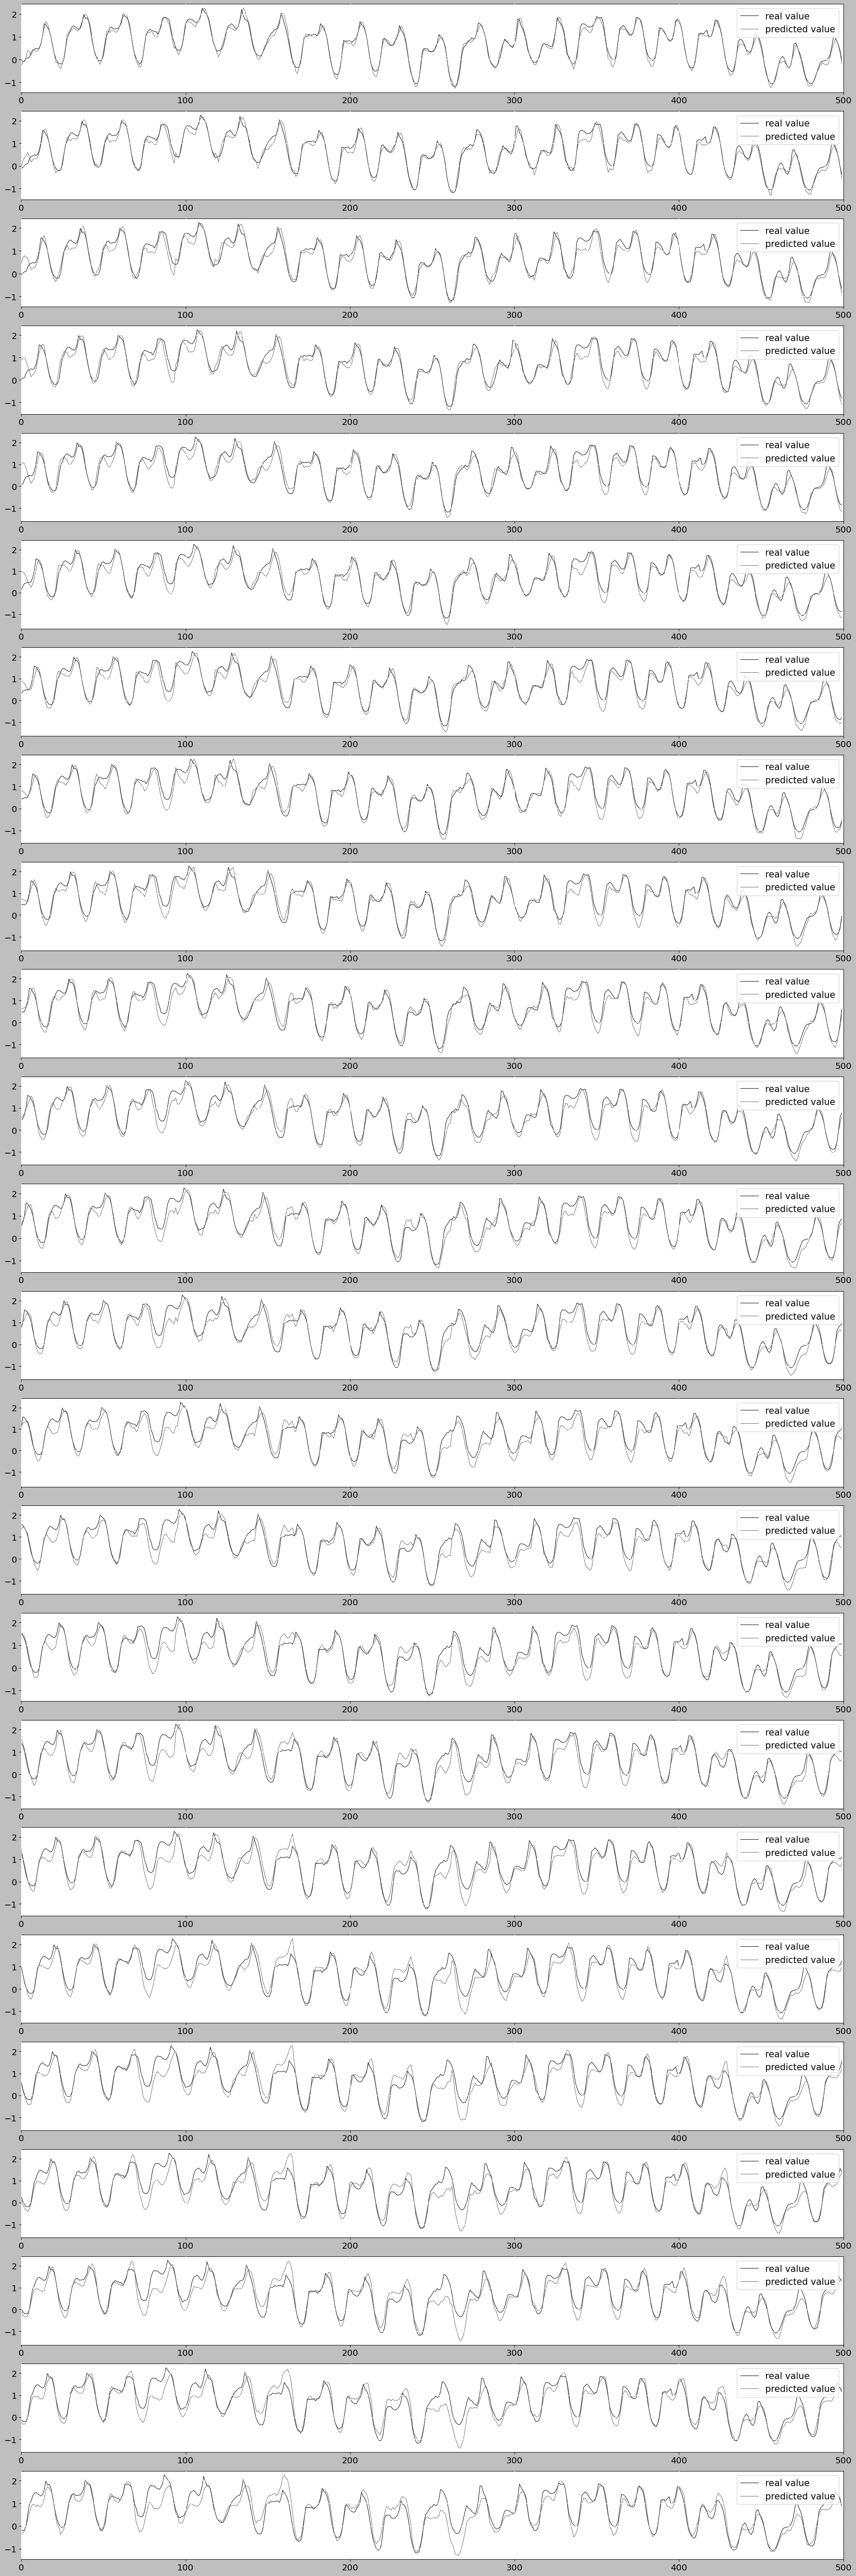

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(24, 1, figsize=(20, 60))  # Create a figure with 12 subplots
y_predict = model.predict(x_test)
y_predict_array = np.array(y_predict)
# y_predict_array = y_predict_array.reshape(len(y_test), 12)
for i in range(24):
    y_test1 = y_test[:, i]
    y_pre = y_predict_array[:, i]
    # print(y_test1.shape, y_pre.shape)
    draw = pd.concat([pd.DataFrame(y_test[:500, i]), pd.DataFrame(y_pre)], axis=1)
    draw.iloc[:, 0].plot(ax=axs[i])  # Plot y_test value in the corresponding subplot
    draw.iloc[:, 1].plot(ax=axs[i])  # Plot predicted value in the corresponding subplot
    axs[i].legend(('real value', 'predicted value'), loc='upper right', fontsize='15')
    # axs[i].title(f"Test Data vs Predicted after {i+1} hours", fontsize='20')
    axs[i].set_xlim(0, len(y_test1[:]))  # Set the x-axis limits for each subplot

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()

## PREDICTION FOR WHOLE YEAR

In [ ]:
pd.set_option('display.max_columns', 100)
dfpredict_data = df_orig.loc['2017', :].copy(deep=True)
predict_data = dfpredict_data[['Temperature', 'Dewpoint Temp', 'Relative Humidity','Wind Speed', 'Visibility', 'Pressure','Hour_of_Day','Month','Day_Of_Week', 'Day_of_Year', 'Week_Of_Year','Quarter']]
predict_data

In [ ]:
scaler=StandardScaler()
predict=scaler.fit_transform(np.array(predict_data))
predict

array([[-0.82381055, -0.3973762 ,  1.41915897, ..., -1.35174944,
        -0.33039956, -0.70281945],
       [-0.84227601, -0.40702618,  1.47816626, ..., -1.35174944,
        -0.33039956, -0.92911582],
       [-0.83304328, -0.40702618,  1.41915897, ..., -1.35174944,
        -0.33039956, -1.10123937],
       ...,
       [-0.18675203,  0.26847195,  1.41915897, ...,  1.33457658,
        -0.46890501, -0.42888175],
       [-0.1498211 ,  0.30707184,  1.41915897, ...,  1.33457658,
        -0.46890501, -0.65440971],
       [-0.14058837,  0.33602176,  1.53717355, ...,  1.33457658,
        -0.46890501, -0.92527377]])

In [ ]:
xp = np.array([np.concatenate((predict[i-2,:], predict[i-1,:], predict[i,:])) for i in range(2, len(predict)-24)])
print(f'xp.shape: {xp.shape}')
yp = np.array([np.stack([predict[i+j+1,-1] for j in range(0, 24)]) for i in range(2, len(predict)-24)])
print(f'yp.shape: {yp.shape}')

xp.shape: (8734, 42)
yp.shape: (8734, 24)


In [ ]:
xp.shape
y_prediction = model.predict(xp)
y_prediction_array = np.array(y_prediction)

273/273 [==============================] - 1s 2ms/step


In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error

mape = mean_absolute_percentage_error(yp, y_prediction)
print("Mean Absolute Percentage Error (MAPE):", mape)
print(yp.shape)
print(y_prediction.shape)
mape_values = []
for actual, predicted in zip(yp, y_prediction):
    mape_values.append(mean_absolute_percentage_error([actual], [predicted]))

worst_mape = np.max(mape_values)
best_mape = np.min(mape_values)

print("Worst MAPE:", worst_mape)
print("Best MAPE:", best_mape)


Mean Absolute Percentage Error (MAPE): 1.9596957884362034
(8734, 24)
(8734, 24)
Worst MAPE: 207.5749857939893
Best MAPE: 0.05021186123857535


##VISUALISATION

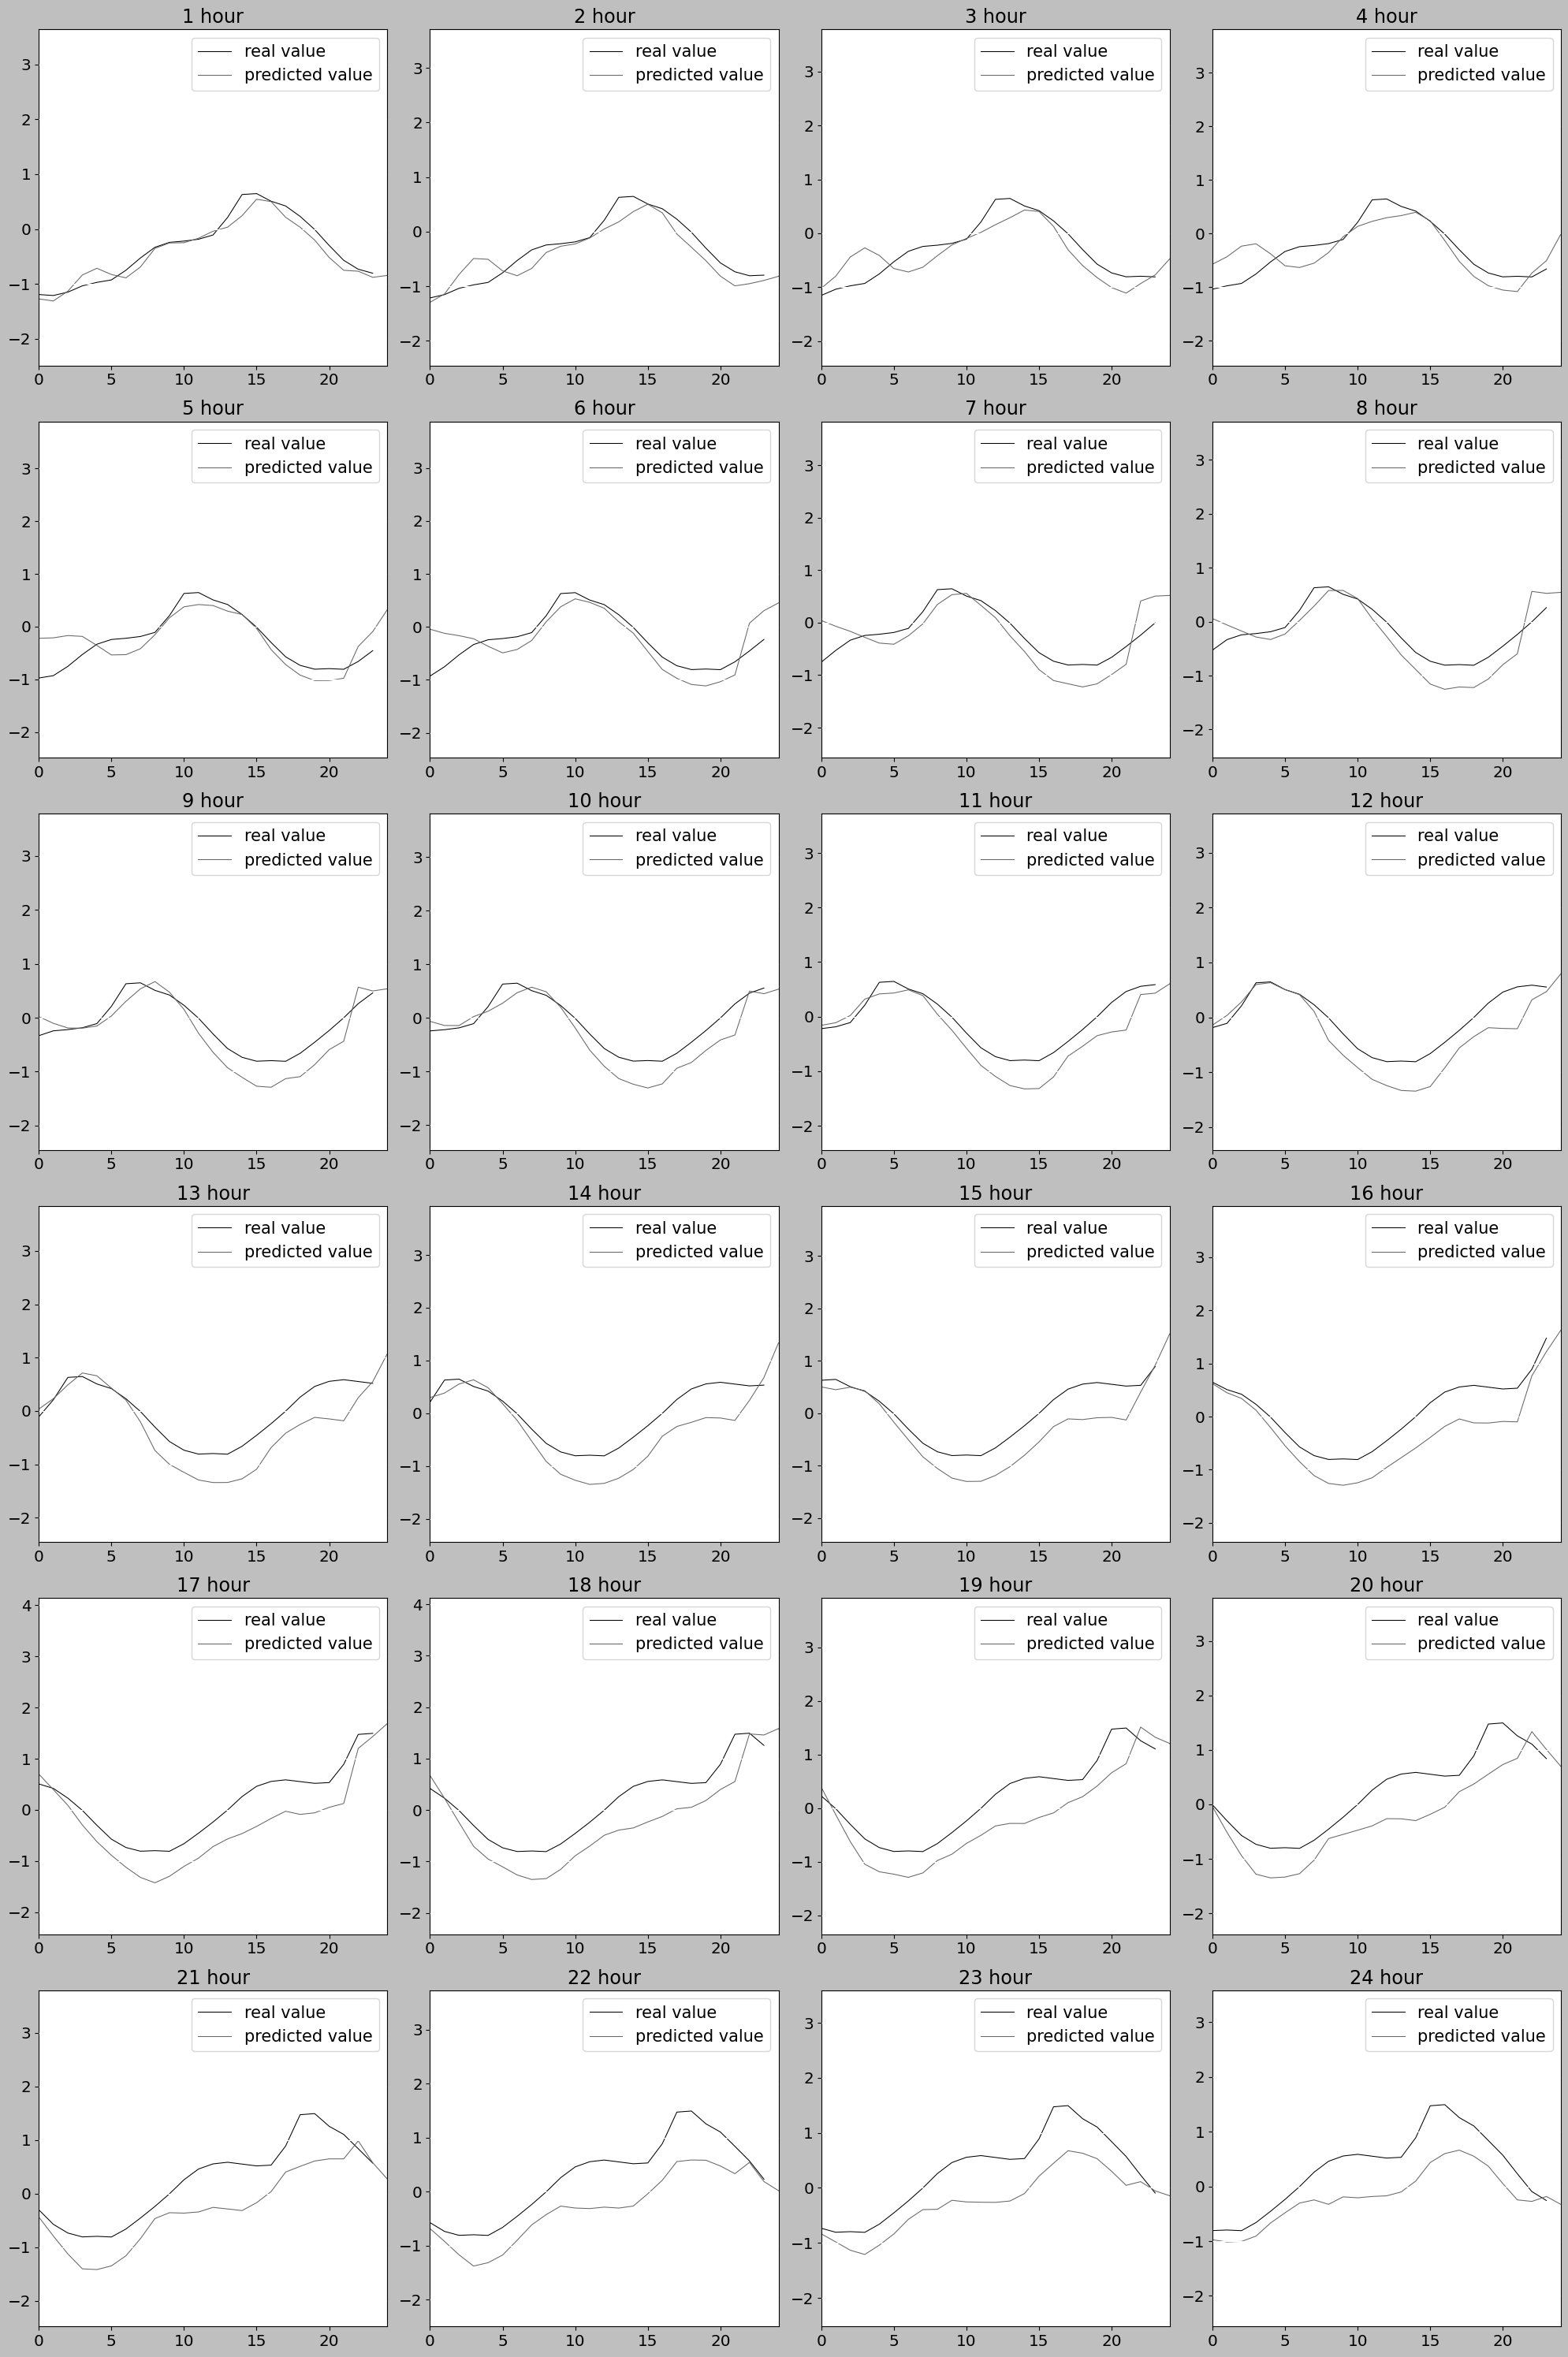

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(6, 4, figsize=(20, 30))  # Create a figure with 6 rows and 4 columns of subplots


for i in range(24):
    row = i // 4  # Calculate the row index for the subplot
    col = i % 4  # Calculate the column index for the subplot

    y_prede = y_prediction_array[:, i]
    draw = pd.concat([pd.DataFrame(yp[:24, i]), pd.DataFrame(y_prede)], axis=1)

    axs[row, col].plot(draw.iloc[:, 0])  # Plot y_test value in the corresponding subplot
    axs[row, col].plot(draw.iloc[:, 1])  # Plot predicted value in the corresponding subplot
    axs[row, col].legend(('real value', 'predicted value'), loc='upper right', fontsize='15')
    axs[row, col].set_xlim(0, len(yp[:24]))  # Set the x-axis limits for each subplot
    axs[row, col].set_title(f"{i+1} hour")  # Add a title to the subplot indicating the hour

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()


In [ ]:
df_predict_aggregate = pd.DataFrame(columns=['prediction_agg', 'actual'])
def aggregate_plot(y_actual, y_pred):
  y_mean_pred = []
  for j in range(23, -1, -1):
    sum=0
    for i in range(0, 24):
      if j-i>=0:
        sum += y_pred[i][j-i]
    y_mean_pred.append(sum/(j+1))
  y_mean_pred = list(reversed(y_mean_pred))
  df_predict_aggregate['prediction_agg'] = y_mean_pred
  df_predict_aggregate['actual'] = y_actual

  mape = mean_absolute_percentage_error(yp, y_prediction)
  print(mape)
  plt.plot(y_actual, marker='*', color='blue')
  plt.plot(y_mean_pred, marker='+', color ='red')
  plt.legend(('real value', 'predicted value'), loc='upper right', fontsize='15')
  plt.show()

In [ ]:
df_predict_aggregate

,prediction_agg,actual


1.9596957884362034


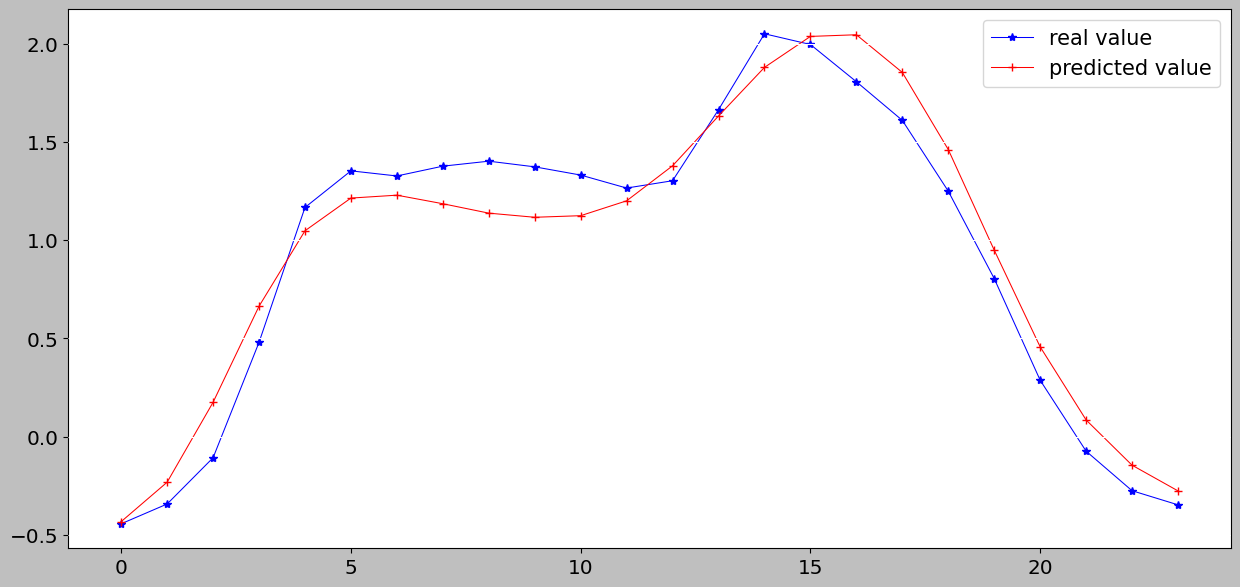

In [ ]:
aggregate_plot(yp[240], y_prediction[240:264])